# Word Embedding Experiments
Here we implement all experiments for evaluating the classification performance of different kinds of pretrained word embeddings for complex word identification.

## (1) Load Data and Embeddings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.wsd import lesk
import nltk
from collections import namedtuple

In [2]:
MAIN_PATH_DATASET = "../cwishareddataset/traindevset/english/"
genres = ['Wikipedia', 'WikiNews', 'News']
datasets = ['Train', 'Dev']
columns = ['id', 'sentence', "start", "end", "target", 
           "nat", "non_nat", "nat_marked", "non_nat_marked", "binary", "prob"]

Model = namedtuple('Model', 'type, name, dimension, corpus, model')
Dataset = namedtuple('Dataset', 'name, train, test')

datasets = [Dataset('Wikipedia', 'Train', 'Dev'),
            Dataset('WikiNews', 'Train', 'Dev'),
            Dataset('News', 'Train', 'Dev')]

def load_df(path):
    df = pd.read_csv(path, header=None, sep = "\t")
    df.columns = columns
    return df.filter(['binary','target'], axis=1)

datasets = [Dataset(d.name, load_df(MAIN_PATH_DATASET + d.name + '_' + d.train + '.tsv'),
                            load_df(MAIN_PATH_DATASET + d.name + '_' + d.test + '.tsv'))
                            for d in datasets]

In [ ]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

MAIN_PATH = 'D:/workspace_python/CoWoReId/python/resources/word-embeddings/'

glove_file = datapath(MAIN_PATH + 'glove.42B.300d.txt')
tmp_file = get_tmpfile("glove2word2vec.txt")

glove2word2vec(glove_file, tmp_file)

model_glove_wiki_50d = KeyedVectors.load_word2vec_format(tmp_file)
#model_word2vec_300d = KeyedVectors.load_word2vec_format(datapath(MAIN_PATH + 'GoogleNews-vectors-negative300.bin'), binary=True)

## (1.1) Load GloVe embeddings

In [3]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

MAIN_PATH = 'D:/workspace_python/CoWoReId/python/resources/word-embeddings/'

glove_defs = [Model('glove', 'glove.42B.300d.txt', 300, 'cc42B', None),  
              Model('glove', 'glove.840B.300d.txt', 300, 'cc840B', None), 
              Model('glove', 'glove.6B.50d.txt', 50, 'wikipedia+gigaword5', None), 
              #Model('glove', 'glove.6B.100d.txt',100, 'wikipedia+gigaword5', None),
              #Model('glove', 'glove.6B.200d.txt', 200, 'wikipedia+gigaword5', None), 
              #Model('glove', 'glove.6B.300d.txt', 300, 'wikipedia+gigaword5', None),
              Model('glove', 'glove.twitter.27B.25d.txt', 25, 'twitter', None)]
              #Model('glove', 'glove.twitter.27B.50d.txt', 50, 'twitter', None), 
              #Model('glove', 'glove.twitter.27B.100d.txt', 100, 'twitter', None), 
              #Model('glove', 'glove.twitter.27B.200d.txt', 200, 'twitter', None)]

glove_models = []
for model in glove_defs:
    glove_file = datapath(MAIN_PATH + model.name)
    tmp_file = get_tmpfile(model.name + '-temp')
    glove2word2vec(glove_file, tmp_file)
    vecs = KeyedVectors.load_word2vec_format(tmp_file)
    glove_models.append(Model(model.type, model.name, model.dimension, model.corpus, vecs))
    print('load model : {}'.format(model.name))
    
print(glove_models)

C:\Users\Studio\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


load model : glove.42B.300d.txt
load model : glove.840B.300d.txt
load model : glove.6B.50d.txt
load model : glove.twitter.27B.25d.txt
[Model(type='glove', name='glove.42B.300d.txt', dimension=300, corpus='cc42B', model=<gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x000000C18B991BE0>), Model(type='glove', name='glove.840B.300d.txt', dimension=300, corpus='cc840B', model=<gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x000000C23D794A58>), Model(type='glove', name='glove.6B.50d.txt', dimension=50, corpus='wikipedia+gigaword5', model=<gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x000000C307B3ED30>), Model(type='glove', name='glove.twitter.27B.25d.txt', dimension=25, corpus='twitter', model=<gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x000000C31518B518>)]


## (1.2) Load word2vec embeddings

In [4]:
from gensim.test.utils import datapath
from gensim.models import KeyedVectors

MAIN_PATH = 'D:/workspace_python/CoWoReId/python/resources/word-embeddings/'
model_word2vec = Model('word2vec', 'GoogleNews-vectors-negative300.bin' , 300, 'GoogleNews', \
            KeyedVectors.load_word2vec_format(datapath(MAIN_PATH + 'GoogleNews-vectors-negative300.bin'), binary=True))

## (1.3) Load FastText embeddings

In [5]:
from gensim.test.utils import datapath
from gensim.models import KeyedVectors
from gensim.models.wrappers import FastText

MAIN_PATH = 'D:/workspace_python/CoWoReId/python/resources/word-embeddings/'
model_fastText = Model('FastText', 'wiki.en.vec', 300, 'Wikipedia', \
                 KeyedVectors.load_word2vec_format(MAIN_PATH + 'wiki.en.vec'))

In [6]:
models = []
models.extend(glove_models)
models.append(model_word2vec)
models.append(model_fastText)

## (1.4) Compute the embeddings

In [26]:
from nltk import word_tokenize

def word_embedding(target, model, missing_strat, ngram_repr, *args):
    tokens = word_tokenize(target)
    if len(tokens) > 1:
        # First construct multi-word query
        query = '_'.join(tokens)
        if query in model.vocab:
            return model[query]
        query = '_'.join([token.strip().lower() for token in tokens])
        if query in model.vocab:
            return model[query]
        all_embeddings = [model[word.strip().lower()] 
                              if word.strip().lower() in model.vocab 
                              else missing_strat(word, model.vector_size) 
                              for word in tokens]
        return ngram_repr(all_embeddings, tokens)
    else:
        if target in model.vocab:
            return model[target]
        else:
            return model[target.strip().lower()] \
                if target.strip().lower() in model.vocab \
                else missing_strat(target, model.vector_size)
                
def word_embedding_ngram_repr(target, model, missing_strat, ngram_repr, *args):
    tokens = word_tokenize(target)
    if len(tokens) > 1:
        # First construct multi-word query
        query = '_'.join(tokens)
        if query in model.vocab:
            return model[query]
        query = '_'.join([token.strip().lower() for token in tokens])
        if query in model.vocab:
            return model[query]
        all_embeddings = [model[word.strip().lower()] 
                              if word.strip().lower() in model.vocab 
                              else missing_strat(word, model.vector_size) 
                              for word in tokens]
        return ngram_repr(all_embeddings, tokens)
    else:
        if target in model.vocab:
            return ngram_repr(model[target], [target])
        else:
            return ngram_repr(model[target.strip().lower()], [target]) \
                if target.strip().lower() in model.vocab \
                else ngram_repr([missing_strat(target, model.vector_size)], [target])

In [9]:
def generate_embedding_feat(df, model, ngram_repr, missing_strat):
    df_copy = df.copy()
    df_copy['word_embedding'] = df_copy['target'].apply(lambda target : \
            word_embedding(target, model = model, missing_strat = missing_strat, 
            ngram_repr = ngram_repr))
    df_embeddings = pd.DataFrame(df_copy['word_embedding'].values.tolist())
    return pd.concat([df_copy.loc[:,['binary']], df_embeddings], axis = 1)

def generate_embedding_feat_ngram_repr(df, model, ngram_repr, missing_strat):
    df_copy = df.copy()
    df_copy['word_embedding'] = df_copy['target'].apply(lambda target : \
            word_embedding_ngram_repr(target, model = model, missing_strat = missing_strat, 
            ngram_repr = ngram_repr))
    df_embeddings = pd.DataFrame(df_copy['word_embedding'].values.tolist())
    return pd.concat([df_copy.loc[:,['binary']], df_embeddings], axis = 1)

def generate_embedding_feat_concat(df, models, ngram_repr, missing_strat):
    df_copy = df.copy()
    df_concat = df_copy.loc[:,['binary']]
    for index, model in enumerate(models):
        df_copy['word_embedding' + str(index)] = df_copy['target'].apply(lambda target : \
            word_embedding(target, model = model, missing_strat = missing_strat, ngram_repr = ngram_repr))
        df_embeddings = pd.DataFrame(df_copy['word_embedding' + str(index)].values.tolist())
        df_embeddings = df_embeddings.add_prefix(str(index) + '_')
        df_concat = pd.concat([df_concat, df_embeddings], axis = 1)
    return df_concat

In [68]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

#Prepare training and test data
x_train = df_f_train.loc[:, df_f_train.columns != 'binary']
y_train = df_f_train.binary.values
x_test = df_f_test.loc[:, df_f_test.columns != 'binary']
y_test = df_f_test.binary.values

#Prepare KNN
knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='distance')
knn.fit(x_train, y_train) 
prediction_knn = knn.predict(x_test)

svc = svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
svc.fit(x_train, y_train)   
prediction_svm = svc.predict(x_test)

from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
iris = load_iris()
cross_val_score(clf, iris.data, iris.target, cv=10)

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn import model_selection
from sklearn.neural_network import MLPClassifier


def average_classification_f1(train, test):
    print('average_classification')
    x_train = train.loc[:, train.columns != 'binary']
    y_train = train.binary.values
    x_test = test.loc[:, test.columns != 'binary']
    y_test = test.binary.values
    seed = 7
    #knn = MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto',
     #  beta_1=0.9, beta_2=0.999, early_stopping=False,
    #   epsilon=1e-08, hidden_layer_sizes=(5, 100), learning_rate='constant',
    #   learning_rate_init=0.001, max_iter=200, momentum=0.9,
    #   nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
    #   solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
    #   warm_start=False)
    knn = svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
        decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
        max_iter=-1, probability=False, random_state=None, shrinking=True,
        tol=0.001, verbose=False)
    knn.fit(x_train, y_train) 
    #prediction = knn.predict(x_test)
    #f1score = f1_score(y_test, prediction)
    kfold = model_selection.KFold(n_splits=2, random_state=seed)
    cv_results = model_selection.cross_val_score(knn, x_train, y_train, cv=kfold, scoring=make_scorer(f1_score))
    return cv_results

In [ ]:
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

#Prepare training and test data
x_train = df_f_train.loc[:, df_f_train.columns != 'binary']
y_train = df_f_train.binary.values
x_test = df_f_test.loc[:, df_f_test.columns != 'binary']
y_test = df_f_test.binary.values

seed = 7
# Build a collection of classification models to evaluate
classifiers = []
classifiers.append(('LR', LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, 
                fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, 
                solver='liblinear', max_iter=100, multi_class='ovr', verbose=0, warm_start=False,
                n_jobs=1)))
classifiers.append(('LDA', LinearDiscriminantAnalysis()))
classifiers.append(('KNN', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='distance')))
classifiers.append(('DT', DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None,
           min_samples_split=2, min_samples_leaf=1, min_impurity_split=0 ,min_weight_fraction_leaf=0.0, max_features=None,
           random_state=None, max_leaf_nodes=None, class_weight=None, presort=False)))
classifiers.append(('SVM', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)))
# evaluate each model in turn
results = []
names = []
for name, model in classifiers:
    kfold = model_selection.KFold(n_splits=2, random_state=seed)
    cv_results = model_selection.cross_val_score(model, x_train, y_train, cv=kfold, scoring=make_scorer(f1_score))
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot results for different classification algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## (1.5) Out-of-Vocabulary Errors

In [ ]:
from collections import namedtuple

SimpleResult = namedtuple('SimpleResult', 'model_name, model_corpus, dataset, oovr')

def word_in_model_vocab(word, model):
    return True if word in model.vocab \
            else word.strip().lower() in model.vocab

def compute_oove_ratio(dataframe, model):
    words = list(set([item for word in dataframe.target.str.split() 
                             for item in word]))
    return 1 - (np.sum([1 for word in words 
                   if word_in_model_vocab(word, model)]) / len(words))

def compute_oove_words(dataframe, model):
    words = list(set([item for word in dataframe.target.str.split() 
                             for item in word]))
    return [word for word in words 
                   if not word_in_model_vocab(word, model)]

oovr_results = [SimpleResult(model.type, model.corpus, dataset.name, 
              compute_oove_ratio(dataset.train.append(dataset.test), model.model)) 
              for dataset in datasets 
              for model in models]
oovr_results

In [ ]:
compute_oove_words(datasets[0].train.append(datasets[0].test), models[0].model)

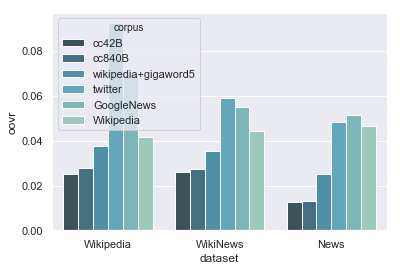

,corpus,dataset,model,oovr
0,cc42B,Wikipedia,glove,0.024949
1,cc840B,Wikipedia,glove,0.027884
2,wikipedia+gigaword5,Wikipedia,glove,0.037570
3,twitter,Wikipedia,glove,0.092457
4,GoogleNews,Wikipedia,word2vec,0.069563
5,Wikipedia,Wikipedia,FastText,0.041679
6,cc42B,WikiNews,glove,0.026085
7,cc840B,WikiNews,glove,0.027457
8,wikipedia+gigaword5,WikiNews,glove,0.035420
9,twitter,WikiNews,glove,0.059033


In [42]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set(style="darkgrid", palette="GnBu_d")

oovr_data = [{'model' : result.model_name, 
                    'dataset' : result.dataset, 'corpus': result.model_corpus , 'oovr' : result.oovr} 
                   for result in oovr_results]
oovr_data = pd.DataFrame.from_records(oovr_data)

oovr_plot = sns.barplot(x="dataset", y="oovr",
             hue="corpus",
             data=oovr_data)
plt.show(oovr_plot)
oovr_data

In [43]:
oovr_plot_fig = oovr_plot.get_figure()
oovr_plot_fig.savefig('D:/workspace_python/CoWoReId/oovr.pdf')

# Experiments
Here we define all the experiments and compute the evaluation results of employing word representations to complex word identification.

In [6]:
from collections import namedtuple
Result = namedtuple('Result', 'model, dataset, measure')
ResultParams = namedtuple('Result', 'model, dataset, params, measure')
FeatureSet = namedtuple('FeatureSet', 'model, dataset, featTrain, featTest')
FeatureSetParams = namedtuple('FeatureSet', 'model, dataset, params, featTrain, featTest')
NGramRepr = namedtuple('NGramRepr', 'name, repr')

## (1) Dimension
First, we want to evaluate the influence of the dimension of the word representation on the three datasets. Therefore we use GloVe embeddings computed on Wikipedia+Gigaword 5 also denoted by 6B (50, 100, 200, 300) and computed on Twitter (25, 50, 100, 200).

In [ ]:
from ngram_representation import ngram_repr_bow_mean
from ngram_representation import missing_strat_random

d_models = [model for model in models
              if ('wikipedia' in model.corpus or 'twitter' in model.corpus)]
data = datasets

ngram_repr = ngram_repr_bow_mean
missing_strat = missing_strat_random

print('Generating features...')

features_data = [FeatureSet(model, d, 
                        generate_embedding_feat(d.train, model.model, ngram_repr, missing_strat),
                        generate_embedding_feat(d.test, model.model, ngram_repr, missing_strat))
                 for model in models 
                 for d in datasets]

print(len(features_data))
print('Evaluating features...')
results = [Result(fs.model, fs.dataset, average_classification_f1(fs.featTrain, fs.featTest)) for fs in features_data]

      dataset  dimension  f1-score
0   Wikipedia         50  0.721835
1    WikiNews         50  0.693772
2        News         50  0.766654
3   Wikipedia        100  0.713281
4    WikiNews        100  0.700641
5        News        100  0.763308
6   Wikipedia        200  0.685092
7    WikiNews        200  0.677316
8        News        200  0.736939
9   Wikipedia        300  0.689111
10   WikiNews        300  0.676716
11       News        300  0.734603
12  Wikipedia         25  0.739968
13   WikiNews         25  0.706891
14       News         25  0.743226
15  Wikipedia         50  0.731062
16   WikiNews         50  0.711757
17       News         50  0.750367
18  Wikipedia        100  0.719968
19   WikiNews        100  0.707012
20       News        100  0.763370
21  Wikipedia        200  0.721649
22   WikiNews        200  0.709904
23       News        200  0.753613


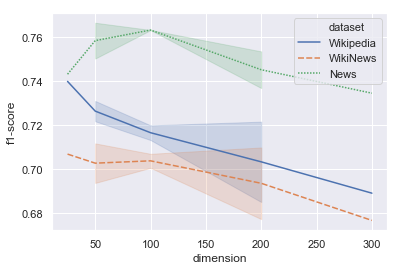

In [104]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

dimensions_data = [{'dimension' : result.model.dimension, 
                    'dataset' : result.dataset.name, 'f1-score' : result.measure[0]} 
                   for result in results]
dimensions_data = pd.DataFrame.from_records(dimensions_data)

dim_plot = sns.lineplot(x="dimension", y="f1-score",
             hue="dataset", style="dataset", err_style = 'band',
             data=dimensions_data)
print(dimensions_data)
plt.show(dim_plot)

In [101]:
dim_fig = dim_plot.get_figure()
dim_fig.savefig('D:/workspace_python/CoWoReId/dim_plot_svm.pdf')

## (2) Corpus
Second, we want to evaluate the influence of the corpus of the word representation on the three datasets. Therefore we use GloVe embeddings computed on Wikipedia+Gigaword 5 also denoted by 6B (50, 100, 200) and computed on Twitter (50, 100, 200). Then we compare the three 300-dimensional corpera used by glove which are Wikipedia+Gigaword 5, CC42B and CC840B.

In [ ]:
from ngram_representation import ngram_repr_bow_mean
from ngram_representation import missing_strat_random

d_models = [model for model in models
              if (('wikipedia' in model.corpus or 'twitter' in model.corpus) 
                  and (model.dimension>=50 and model.dimension <=200))]
data = datasets

ngram_repr = ngram_repr_bow_mean
missing_strat = missing_strat_random

print('Generating features...')

features_data = [FeatureSet(model, d, 
                        generate_embedding_feat(d.train, model.model, ngram_repr, missing_strat),
                        generate_embedding_feat(d.test, model.model, ngram_repr, missing_strat))
                 for model in d_models 
                 for d in datasets]

test_features = [fs for fs in features_data if fs.model.dimension==50 and fs.dataset.name == 'Wikipedia']

print('Evaluating features...')
results = [Result(fs.model, fs.dataset, average_classification_f1(fs.featTrain, fs.featTest)) for fs in features_data]

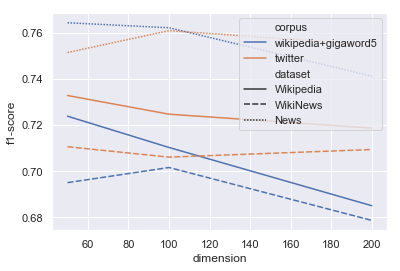

In [107]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

corpus_data = [{'dimension' : result.model.dimension, 
                    'dataset' : result.dataset.name, 'corpus': result.model.corpus , 'f1-score' : result.measure[0]} 
                   for result in results]
corpus_data = pd.DataFrame.from_records(corpus_data)

corpus_plot = sns.lineplot(x="dimension", y="f1-score",
             hue="corpus", style="dataset", err_style = 'band',
             data=corpus_data)
plt.show(corpus_plot)

In [104]:
corpus_plot = corpus_plot.get_figure()
corpus_plot.savefig('D:/workspace_python/CoWoReId/dim_plot_corpus.pdf')

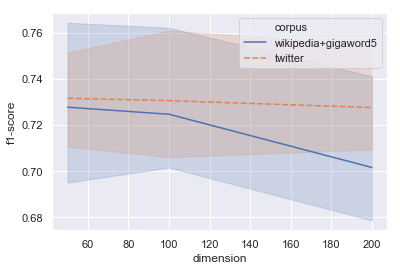

In [105]:
corpus_plot_agg = sns.lineplot(x="dimension", y="f1-score",
             hue="corpus", style="corpus", err_style = 'band',
             data=corpus_data)
plt.show(corpus_plot_agg)

In [106]:
corpus_plot_agg_fig = corpus_plot_agg.get_figure()
corpus_plot_agg_fig.savefig('D:/workspace_python/CoWoReId/dim_plot_corpus_agg.pdf')

In [ ]:
from ngram_representation import ngram_repr_bow_mean
from ngram_representation import missing_strat_random

d_models = [model for model in models
              if model.dimension == 300]
data = datasets

ngram_repr = ngram_repr_bow_mean
missing_strat = missing_strat_random

print('Generating features...')

features_data = [FeatureSet(model, d, 
                        generate_embedding_feat(d.train, model.model, ngram_repr, missing_strat),
                        generate_embedding_feat(d.test, model.model, ngram_repr, missing_strat))
                 for model in d_models 
                 for d in datasets]

print(len(features_data))
print('Evaluating features...')
results = [Result(fs.model, fs.dataset, average_classification_f1(fs.featTrain, fs.featTest)) for fs in features_data]

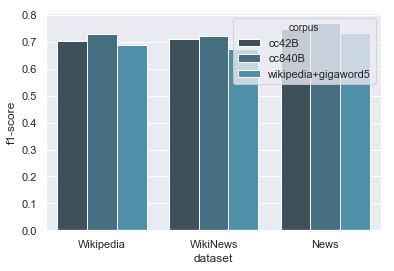

In [62]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set(style="darkgrid", palette="GnBu_d")

corpus_data_300 = [{'dimension' : result.model.dimension, 
                    'dataset' : result.dataset.name, 'corpus': result.model.corpus , 'f1-score' : result.measure[0]} 
                   for result in results]
corpus_data_300 = pd.DataFrame.from_records(corpus_data_300)

corpus_plot_300 = sns.barplot(x="dataset", y="f1-score",
             hue="corpus",
             data=corpus_data_300)
plt.show(corpus_plot_300)

In [60]:
corpus_plot_300_fig = corpus_plot_300.get_figure()
corpus_plot_300_fig.savefig('D:/workspace_python/CoWoReId/dim_plot_corpus_300.pdf')

## (3) Model
Third, we want to evaluate the influence of the model used to train the word representation on the three datasets. Therefore we use GloVe (300), word2Vec (300) and FastText (300).

In [125]:
from ngram_representation import ngram_repr_bow_mean
from ngram_representation import missing_strat_random

d_models = [model for model in models
              if (model.dimension == 300)]
data = datasets

ngram_repr = ngram_repr_bow_mean
missing_strat = missing_strat_random

print('Generating features...')

features_data = [FeatureSet(model, d, 
                        generate_embedding_feat(d.train, model.model, ngram_repr, missing_strat),
                        generate_embedding_feat(d.test, model.model, ngram_repr, missing_strat))
                 for model in d_models 
                 for d in datasets]

test_features = [fs for fs in features_data if fs.model.dimension==50 and fs.dataset.name == 'Wikipedia']

print('Evaluating features...')
results = [Result(fs.model, fs.dataset, average_classification_f1(fs.featTrain, fs.featTest)) for fs in features_data]

Generating features...
Evaluating features...
average_classification
average_classification
average_classification
average_classification
average_classification
average_classification
average_classification
average_classification
average_classification


     dataset  dimension  f1-score     model
0  Wikipedia        300  0.689111     glove
1   WikiNews        300  0.676716     glove
2       News        300  0.734603     glove
3  Wikipedia        300  0.496983  word2vec
4   WikiNews        300  0.488283  word2vec
5       News        300  0.637511  word2vec
6  Wikipedia        300  0.538182  FastText
7   WikiNews        300  0.603957  FastText
8       News        300  0.674527  FastText


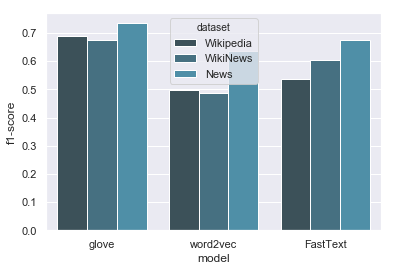

In [147]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set(style="darkgrid", palette="GnBu_d")

model_data = [{'dimension' : result.model.dimension, 
                    'dataset' : result.dataset.name, 'model': result.model.type , 'f1-score' : result.measure[0]} 
                   for result in results]
model_data = pd.DataFrame.from_records(model_data)

model_plot = sns.barplot(x="model", y="f1-score", hue="dataset", data=model_data)
print(model_data)
plt.show(model_plot)

In [148]:
model_plot = model_plot.get_figure()
model_plot.savefig('D:/workspace_python/CoWoReId/model_plot.pdf')

## (4) Concatenations
Third, we want to evaluate the influence of the concatenating different kinds of word representations on the three datasets. Therefore we use GloVe (300), word2Vec (300) and FastText (300) word embeddings and experiment with different kinds of concatenations. First we focus on evaluating 2-combinations of word representations and generate the cross product. For example, we observe that concatenating glove50-wiki with glove50-twitter outperforms the single models with dimension 50 but also outperforms the single models with dimension 100 i.e. glove100-wiki and glove100-twitter.

In [ ]:
from ngram_representation import ngram_repr_bow_mean
from ngram_representation import missing_strat_random

d_models = [model for model in models
              if (model.dimension >= 50 and model.dimension <=200)]
data = datasets

ngram_repr = ngram_repr_bow_mean
missing_strat = missing_strat_random

print('Generating features...')

features_data = [FeatureSet((model1, model2), d, 
                        generate_embedding_feat_concat(d.train, [model1.model, model2.model], ngram_repr, missing_strat),
                        generate_embedding_feat_concat(d.test, [model1.model, model2.model], ngram_repr, missing_strat))
                 for model1 in d_models
                 for model2 in d_models
                 for d in datasets if model1 != model2]

len(features_data)
print('Evaluating features...')
results = [Result(fs.model, fs.dataset, average_classification_f1(fs.featTrain, fs.featTest)) for fs in features_data]

      dataset   dimension  f1-score  \
0   Wikipedia   (50, 100)  0.727719   
1    WikiNews   (50, 100)  0.707379   
2        News   (50, 100)  0.766987   
3   Wikipedia   (50, 200)  0.710127   
4    WikiNews   (50, 200)  0.691553   
5        News   (50, 200)  0.754759   
6   Wikipedia    (50, 50)  0.735329   
7    WikiNews    (50, 50)  0.718336   
8        News    (50, 50)  0.769717   
9   Wikipedia   (50, 100)  0.724486   
10   WikiNews   (50, 100)  0.718373   
11       News   (50, 100)  0.774755   
12  Wikipedia   (50, 200)  0.730261   
13   WikiNews   (50, 200)  0.716104   
14       News   (50, 200)  0.772777   
15  Wikipedia   (100, 50)  0.727719   
16   WikiNews   (100, 50)  0.707379   
17       News   (100, 50)  0.766987   
18  Wikipedia  (100, 200)  0.706854   
19   WikiNews  (100, 200)  0.696486   
20       News  (100, 200)  0.753741   
21  Wikipedia   (100, 50)  0.728300   
22   WikiNews   (100, 50)  0.722605   
23       News   (100, 50)  0.771865   
24  Wikipedia  (100, 100)

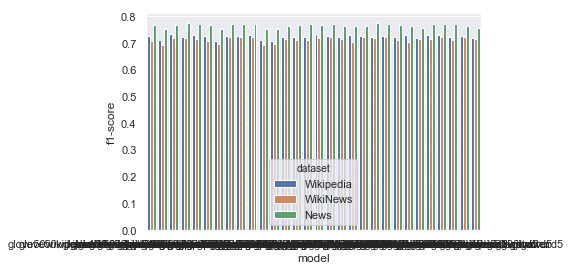

In [114]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

concat_model_data = [{'dimension' : (result.model[0].dimension + result.model[1].dimension),
                      'dataset' : result.dataset.name, 
                      'model': (result.model[0].type + \
                                str(result.model[0].dimension) + result.model[0].corpus \
                                + result.model[1].type +
                               str(result.model[1].dimension) + result.model[1].corpus) , 
                      'f1-score' : result.measure[0]} 
                      for result in results]
concat_model_data = pd.DataFrame.from_records(concat_model_data)

concat_model_plot = sns.barplot(x="model", y="f1-score", hue="dataset", data=concat_model_data)
print(concat_model_data)
plt.show(concat_model_plot)

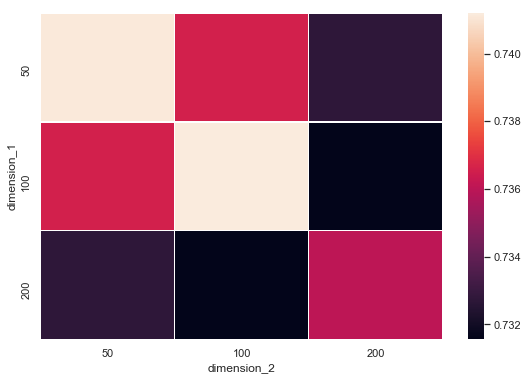

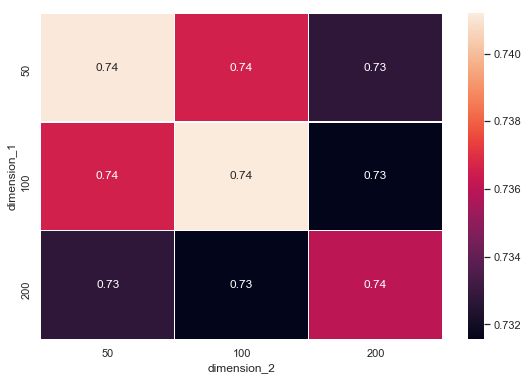

In [125]:
concat_model_data = [{'dimension_1' : result.model[0].dimension,
                      'dimension_2' : result.model[1].dimension,
                      'dataset' : result.dataset.name, 
                      'model': (result.model[0].type + \
                                str(result.model[0].dimension) + result.model[0].corpus \
                                + result.model[1].type +
                               str(result.model[1].dimension) + result.model[1].corpus) , 
                      'f1-score' : result.measure[0]} 
                      for result in results]
concat_model_data = pd.DataFrame.from_records(concat_model_data)
concat_data = pd.pivot_table(concat_model_data, values='f1-score', index='dimension_1', columns='dimension_2', aggfunc='mean')
f, ax = plt.subplots(figsize=(9, 6))
heatmap_concats = sns.heatmap(concat_data, annot=True, linewidths=.5, ax=ax)
plt.show(heatmap_concats)

In [99]:
concat_model_plot_fig = concat_model_plot.get_figure()
concat_model_plot_fig.savefig('D:/workspace_python/CoWoReId/concat_models.pdf')

NameError: name 'concat_model_plot' is not defined

## (5) NGram Representation
Here we investigate the performance of different kinds of aggregation methods for constructing ngram vector representations for MWE. Here it may be meaningful to filter the data first to only include e.g. bigrams, trigrams or ngrams. Then we compute classification scores for multiple classifiers/datasets/models and maybe aggregate them. Then we can visualize the individual ngram aggregation method scores.

In [71]:
MAIN_PATH_DATASET = "../cwishareddataset/traindevset/english/"
genres = ['Wikipedia', 'WikiNews', 'News']
datasets = ['Train', 'Dev']
columns = ['id', 'sentence', "start", "end", "target", 
           "nat", "non_nat", "nat_marked", "non_nat_marked", "binary", "prob"]

Model = namedtuple('Model', 'type, name, dimension, corpus, model')
Dataset = namedtuple('Dataset', 'name, train, test')

datasets_init = [Dataset('Wikipedia', 'Train', 'Dev'),
            Dataset('WikiNews', 'Train', 'Dev'),
            Dataset('News', 'Train', 'Dev')]

def load_df(path):
    df = pd.read_csv(path, header=None, sep = "\t")
    df.columns = columns
    df['length'] = df.target.apply(lambda target : len(target.split()))
    return df.filter(['binary','target', 'length'], axis=1)

datasets = [Dataset(d.name, load_df(MAIN_PATH_DATASET + d.name + '_' + d.train + '.tsv'),
                            load_df(MAIN_PATH_DATASET + d.name + '_' + d.test + '.tsv')) for d in datasets_init]

In [12]:
word_freq_wiki = {}
sum_counts = 0
with open("resources/word-freq-dumps/enwiki-20150602-words-frequency.txt", encoding="utf8") as file:
    for line in file:
        word, freq = line.partition(" ")[::2]
        sum_counts+=int(freq)
        word_freq_wiki[word.strip()] = int(freq)
        
# This is with a laplace smoothing
def get_unigram_probability(word):
    if word not in word_freq_wiki:
        word = word.strip().lower() 
    return word_freq_wiki.get(word, 1) / (sum_counts + len(word_freq_wiki))

### (5.1) Influence of different NGram Representations

In [ ]:
from ngram_representation import ngram_repr_bow_mean
from ngram_representation import ngram_repr_bow_median
from ngram_representation import ngram_repr_bow_max
from ngram_representation import ngram_repr_bow_min
from ngram_representation import ngram_repr_weighted_bow

from ngram_representation import missing_strat_random
from ngram_representation import missing_strat_zeros

d_models = [model for model in models
              ]
data = datasets

NGramRepr = namedtuple('NGramRepr', 'name, repr')

ngram_weighted_bow_bind_medium_alpha = lambda vecs, words : ngram_repr_weighted_bow(vecs, words, 0.0001, \
                                                        get_unigram_probability, ngram_repr_bow_mean)

ngram_reprs = [NGramRepr('BoW', ngram_repr_bow_mean), NGramRepr('median', ngram_repr_bow_median),
               NGramRepr('max', ngram_repr_bow_max), NGramRepr('min', ngram_repr_bow_min) ,
               NGramRepr('w-BoW', ngram_weighted_bow_bind_medium_alpha)]
missing_strat = missing_strat_random

print('Generating features...')

features_data = [FeatureSetParams(model, d, ngram_repr,
                        generate_embedding_feat(d.train, model.model, ngram_repr.repr, missing_strat),
                        generate_embedding_feat(d.test, model.model, ngram_repr.repr, missing_strat))
                 for ngram_repr in ngram_reprs
                 for model in d_models 
                 for d in datasets]


print('Evaluating features...')
results = [ResultParams(fs.model, fs.dataset, fs.params, average_classification_f1(fs.featTrain, fs.featTest)) for fs in features_data]

       dataset  dimension  f1-score     model ngram_repr
0    Wikipedia         50  0.723841     glove        BoW
1     WikiNews         50  0.695059     glove        BoW
2         News         50  0.764322     glove        BoW
3    Wikipedia        100  0.710296     glove        BoW
4     WikiNews        100  0.701621     glove        BoW
5         News        100  0.762150     glove        BoW
6    Wikipedia        200  0.685046     glove        BoW
7     WikiNews        200  0.678698     glove        BoW
8         News        200  0.741163     glove        BoW
9    Wikipedia        300  0.675676     glove        BoW
10    WikiNews        300  0.677999     glove        BoW
11        News        300  0.731247     glove        BoW
12   Wikipedia         25  0.739306     glove        BoW
13    WikiNews         25  0.711715     glove        BoW
14        News         25  0.742433     glove        BoW
15   Wikipedia         50  0.732800     glove        BoW
16    WikiNews         50  0.71

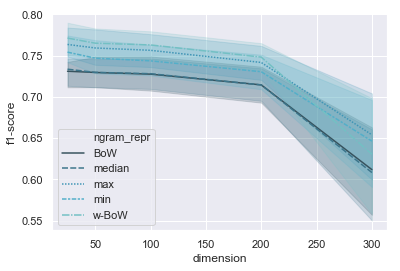

In [58]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set(style="darkgrid", palette="GnBu_d")

ngram_data = [{'dimension' : result.model.dimension, 
               'dataset' : result.dataset.name, 'model': result.model.type , 
               'ngram_repr': result.params.name, 'f1-score' : result.measure[0]} 
                for result in results]
ngram_data = pd.DataFrame.from_records(ngram_data)

ngram_plot = sns.lineplot(x="dimension", y="f1-score",
             hue="ngram_repr", style="ngram_repr", err_style = 'band',
             data=ngram_data)
print(ngram_data)
plt.show(ngram_plot)

In [63]:
ngram_plot_fig = ngram_plot.get_figure()
ngram_plot_fig.savefig('D:/workspace_python/CoWoReId/ngram_plot_dim.pdf')

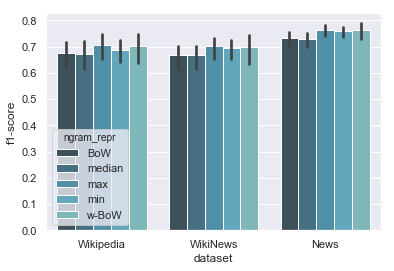

In [59]:
ngram_plot_per_dataset = sns.barplot(x="dataset", y="f1-score", hue="ngram_repr", data=ngram_data)
plt.show()

In [60]:
ngram_plot_per_dataset_fig = ngram_plot_per_dataset.get_figure()
ngram_plot_per_dataset_fig.savefig('D:/workspace_python/CoWoReId/ngram_per_dataset_all.pdf')

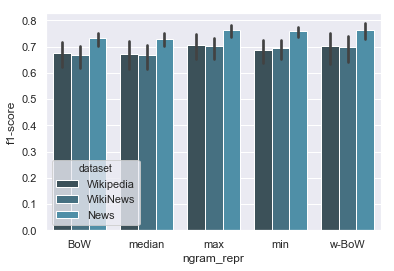

In [61]:
ngram_plot_per_repr = sns.barplot(x="ngram_repr", y="f1-score", hue="dataset", data=ngram_data)
plt.show()

In [62]:
ngram_plot_per_repr_fig = ngram_plot_per_repr.get_figure()
ngram_plot_per_repr_fig.savefig('D:/workspace_python/CoWoReId/ngram_per_repr_all.pdf')

### (5.2) Influence of alpha to w-BoW Representation

In [ ]:
from ngram_representation import ngram_repr_bow_mean
from ngram_representation import ngram_repr_bow_median
from ngram_representation import ngram_repr_bow_max
from ngram_representation import ngram_repr_bow_min
from ngram_representation import ngram_repr_weighted_bow

from ngram_representation import missing_strat_random
from ngram_representation import missing_strat_zeros

d_models = [model for model in models
              if (model.dimension == 50)]
data = datasets

NGramRepr = namedtuple('NGramRepr', 'name, repr')

ngram_weighted_bow_bind_small_alpha = lambda vecs, words : ngram_repr_weighted_bow(vecs, words, 0.00001, \
                                               get_unigram_probability, ngram_repr_bow_mean)
ngram_weighted_bow_bind_medium_alpha = lambda vecs, words : ngram_repr_weighted_bow(vecs, words, 0.0001, \
                                               get_unigram_probability, ngram_repr_bow_mean)
ngram_weighted_bow_bind_large_alpha = lambda vecs, words : ngram_repr_weighted_bow(vecs, words, 0.001, \
                                               get_unigram_probability, ngram_repr_bow_mean)
ngram_weighted_bow_bind_xlarge_alpha = lambda vecs, words : ngram_repr_weighted_bow(vecs, words, 0.01, \
                                               get_unigram_probability, ngram_repr_bow_mean)

ngram_reprs = [NGramRepr('BoW', ngram_repr_bow_mean),
               NGramRepr('w-BoW-s', ngram_weighted_bow_bind_small_alpha),
               NGramRepr('w-BoW-m', ngram_weighted_bow_bind_medium_alpha),
               NGramRepr('w-BoW-l', ngram_weighted_bow_bind_medium_alpha),
               NGramRepr('w-BoW-ll', ngram_weighted_bow_bind_medium_alpha)]
missing_strat = missing_strat_random

print('Generating features...')

features_data = [FeatureSetParams(model, d, ngram_repr,
                        generate_embedding_feat(d.train, model.model, ngram_repr.repr, missing_strat),
                        generate_embedding_feat(d.test, model.model, ngram_repr.repr, missing_strat))
                 for ngram_repr in ngram_reprs
                 for model in d_models 
                 for d in datasets]

print(len(features_data))
print('Evaluating features...')
results = [ResultParams(fs.model, fs.dataset, fs.params, average_classification_f1(fs.featTrain, fs.featTest)) for fs in features_data]

      dataset  dimension  f1-score  model ngram_repr
0   Wikipedia         50  0.723841  glove        BoW
1    WikiNews         50  0.695059  glove        BoW
2        News         50  0.764322  glove        BoW
3   Wikipedia         50  0.732800  glove        BoW
4    WikiNews         50  0.710618  glove        BoW
5        News         50  0.751416  glove        BoW
6   Wikipedia         50  0.744873  glove    w-BoW-s
7    WikiNews         50  0.737399  glove    w-BoW-s
8        News         50  0.797861  glove    w-BoW-s
9   Wikipedia         50  0.760127  glove    w-BoW-s
10   WikiNews         50  0.755303  glove    w-BoW-s
11       News         50  0.795443  glove    w-BoW-s
12  Wikipedia         50  0.749899  glove    w-BoW-m
13   WikiNews         50  0.735000  glove    w-BoW-m
14       News         50  0.798973  glove    w-BoW-m
15  Wikipedia         50  0.759113  glove    w-BoW-m
16   WikiNews         50  0.755462  glove    w-BoW-m
17       News         50  0.792815  glove    w

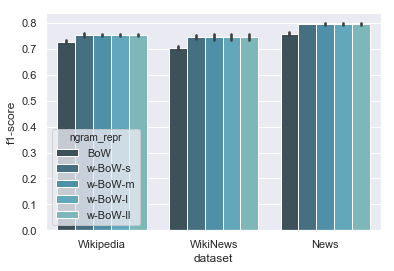

In [97]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set(style="darkgrid", palette="GnBu_d")

ngram_data_alpha = [{'dimension' : result.model.dimension, 
               'dataset' : result.dataset.name, 'model': result.model.type , 
               'ngram_repr': result.params.name, 'f1-score' : result.measure[0]} 
                for result in results]
ngram_data_alpha = pd.DataFrame.from_records(ngram_data_alpha)

ngram_alpha_plot = sns.barplot(x="dataset", y="f1-score", hue="ngram_repr", data=ngram_data_alpha)

print(ngram_data_alpha)
plt.show(ngram_alpha_plot)

In [98]:
ngram_alpha_plot_fig = ngram_alpha_plot.get_figure()
ngram_alpha_plot_fig.savefig('D:/workspace_python/CoWoReId/ngram_alpha.pdf')

### (5.3) NGram Representation Influence on N-Gram level

In [ ]:
from ngram_representation import ngram_repr_bow_mean
from ngram_representation import ngram_repr_bow_median
from ngram_representation import ngram_repr_bow_max
from ngram_representation import ngram_repr_bow_min
from ngram_representation import ngram_repr_weighted_bow

from ngram_representation import missing_strat_random
from ngram_representation import missing_strat_zeros

d_models = [model for model in models]
data = datasets

ngram_weighted_bow_bind = lambda vecs, words : ngram_repr_weighted_bow(vecs, words, 0.0001, \
                                                        get_unigram_probability, ngram_repr_bow_mean)

ngram_reprs = [NGramRepr('BoW', ngram_repr_bow_mean), NGramRepr('median', ngram_repr_bow_median),
               NGramRepr('max', ngram_repr_bow_max), NGramRepr('min', ngram_repr_bow_min) ,
               NGramRepr('w-BoW', ngram_weighted_bow_bind)]
missing_strat = missing_strat_random

print('Generating features...')

features_data = [FeatureSetParams(model, d, ngram_repr,
                        generate_embedding_feat(d.train, model.model, ngram_repr.repr, missing_strat),
                        generate_embedding_feat(d.test, model.model, ngram_repr.repr, missing_strat))
                 for ngram_repr in ngram_reprs
                 for model in d_models 
                 for d in datasets]


print('Evaluating features...')
results = [ResultParams(fs.model, fs.dataset, fs.params, average_classification_f1(fs.featTrain, fs.featTest)) for fs in features_data]

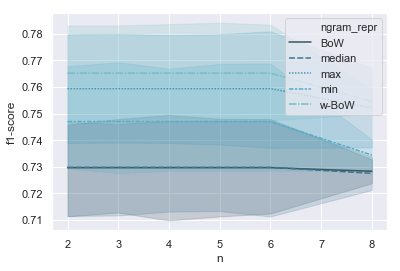

In [91]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set(style="darkgrid", palette="GnBu_d")

ngram_data_per_n = [{'dimension' : result.model.dimension, 
               'dataset' : result.dataset.name, 'model': result.model.type , 
               'ngram_repr': result.params[0].name, 'n': result.params[1] , 'f1-score' : result.measure[0]} 
                for result in results]
ngram_data_per_n = pd.DataFrame.from_records(ngram_data_per_n)

ngram_plot_per_nn = sns.lineplot(x="n", y="f1-score",
             hue="ngram_repr", style="ngram_repr", err_style = 'band',
             data=ngram_data_per_n)
ngram_plot_per_nn
plt.show()

In [79]:
ngram_plot_per_n_fig = ngram_plot_per_n.get_figure()
ngram_plot_per_n_fig.savefig('D:/workspace_python/CoWoReId/ngram_per_n.pdf')

### (5.4) Influence of Concatenation of NGram Representations

In [ ]:
from ngram_representation import ngram_repr_bow_mean
from ngram_representation import ngram_repr_bow_median
from ngram_representation import ngram_repr_bow_max
from ngram_representation import ngram_repr_bow_min
from ngram_representation import ngram_repr_weighted_bow
from ngram_representation import ngram_repr_bow_concat

from ngram_representation import missing_strat_random
from ngram_representation import missing_strat_zeros

d_models = [model for model in models if (model.dimension == 50)]
data = datasets
ngram_weighted_bow_bind = lambda vecs, words : ngram_repr_weighted_bow(vecs, words, 0.0001, \
                                               get_unigram_probability, ngram_repr_bow_mean)

ngram_repr_bow_concat_min_max = lambda vecs, words : \
            ngram_repr_bow_concat(vecs, [ngram_repr_bow_min, ngram_repr_bow_max])
ngram_repr_bow_concat_wBoW_min = lambda vecs, words : \
            ngram_repr_bow_concat(vecs, [ngram_repr_bow_min, ngram_weighted_bow_bind], words)
ngram_repr_bow_concat_wBoW_max = lambda vecs, words : \
            ngram_repr_bow_concat(vecs, [ngram_repr_bow_max, ngram_weighted_bow_bind], words)
ngram_repr_bow_concat_wBoW_min_max = lambda vecs, words : \
            ngram_repr_bow_concat(vecs, [ngram_repr_bow_min, ngram_repr_bow_max, ngram_weighted_bow_bind], words)

ngram_reprs = [NGramRepr('BoW', ngram_repr_bow_mean),
               NGramRepr('median', ngram_repr_bow_median),
               NGramRepr('min', ngram_repr_bow_min),
               NGramRepr('max', ngram_repr_bow_max),
               NGramRepr('w-BoW', ngram_weighted_bow_bind),
               NGramRepr('mima', ngram_repr_bow_concat_min_max),
               NGramRepr('miWB', ngram_repr_bow_concat_wBoW_min),
               NGramRepr('maWB', ngram_repr_bow_concat_wBoW_max),
               NGramRepr('mimaWB', ngram_repr_bow_concat_wBoW_min_max)]

missing_strat = missing_strat_random

print('Generating features...')
features_data = [FeatureSetParams(model, d, ngram_repr,
                        generate_embedding_feat_ngram_repr(d.train, model.model, ngram_repr.repr, missing_strat),
                        generate_embedding_feat_ngram_repr(d.test, model.model, ngram_repr.repr, missing_strat))
                 for ngram_repr in ngram_reprs
                 for model in d_models 
                 for d in datasets]

print(len(features_data))
print('Evaluating features...')
results = [ResultParams(fs.model, fs.dataset, fs.params, average_classification_f1(fs.featTrain, fs.featTest)) for fs in features_data]

  ngram_repr  f1-score
0        BoW  0.730004
3     median  0.730891
7        min  0.746676
2        max  0.759472
5       mima  0.761684
4       miWB  0.764420
1       maWB  0.765146
6     mimaWB  0.765576
8      w-BoW  0.765721


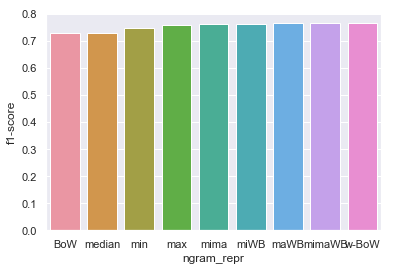

In [47]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set(style="darkgrid", palette="GnBu_d")

ngram_concat = [{'dimension' : result.model.dimension, 
               'dataset' : result.dataset.name, 'model': result.model.type , 
               'ngram_repr': result.params.name , 'f1-score' : result.measure[0]} 
                for result in results]
ngram_concat = pd.DataFrame.from_records(ngram_concat)
ngram_concat = ngram_concat.groupby(["ngram_repr"])['f1-score'].aggregate(np.mean).reset_index().sort_values('f1-score')
print(ngram_concat)

ngram_concat_plot = sns.barplot(x="ngram_repr", y="f1-score", data=ngram_concat)
ngram_concat_plot
plt.show()

In [45]:
ngram_concat_plot_fig = ngram_concat_plot.get_figure()
ngram_concat_plot_fig.savefig('D:/workspace_python/CoWoReId/ngram_repr_concats_order.pdf')